In [1]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

print("Import is done!")

Import is done!


In [2]:
def calibrate_camera(images_folder, nx=9, ny=6):
    
    images = glob.glob(images_folder + '*.jpg')
    
    objpoints = []
    imgpoints = []
    
    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    
    for f in images:
        image = cv2.imread(f)
        
        gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist

mtx, dist = calibrate_camera("camera_cal/")
    

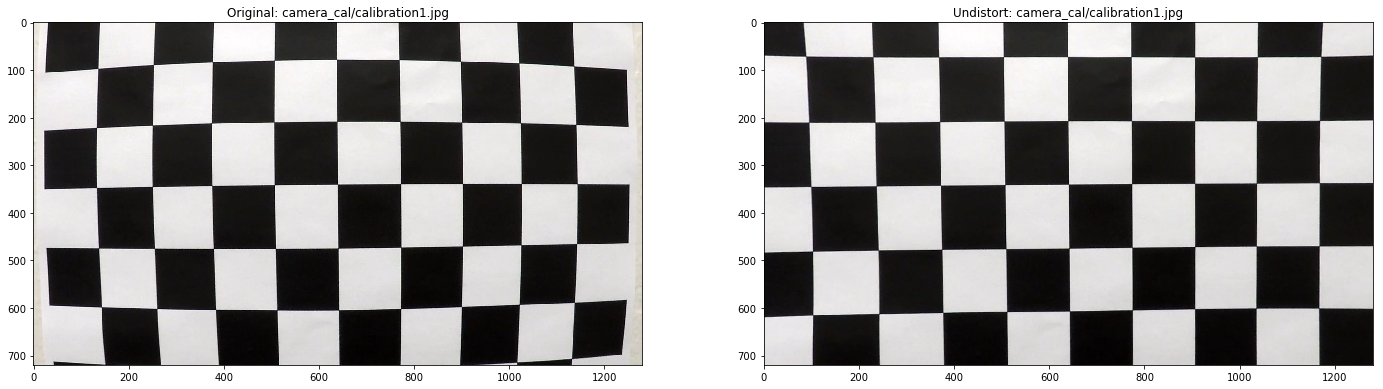

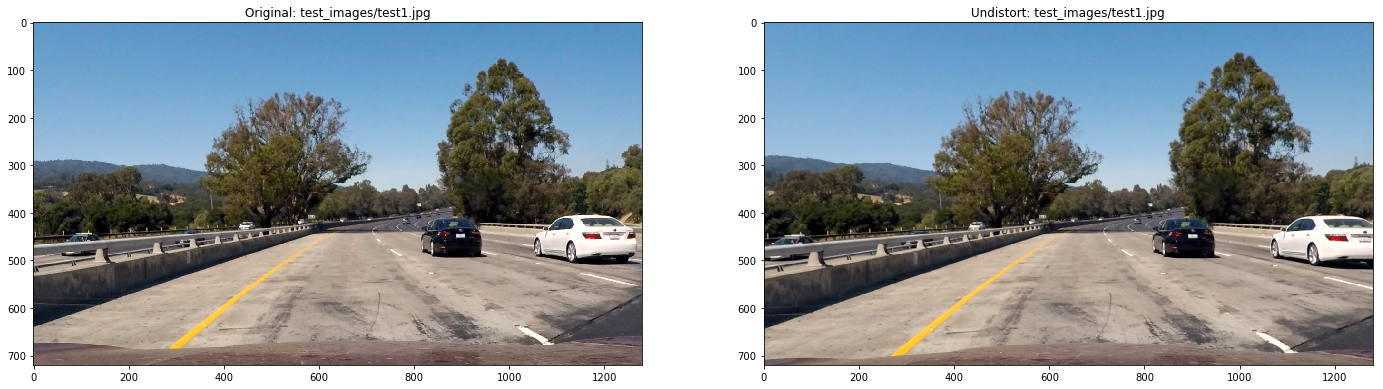

In [3]:
# Check how camera was calibrated.

def test_calibration(files, mtx, dist):
    
    for file in files:
        image = cv2.imread(file)
        
        dst = cv2.undistort(image, mtx, dist, None, mtx)
        f, (p1, p2) = plt.subplots(1,2, figsize=(24,9))
        p1.set_title("Original: " + file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        p1.imshow(image)
        
        p2.set_title("Undistort: " + file)
        dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
        p2.imshow(dst)
        plt.show()
    
test_calibration(["camera_cal/calibration1.jpg",
                  "test_images/test1.jpg"], mtx, dist)

# Pipe lines

In [4]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == "x":
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
        
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sbinary
    
image = cv2.imread('test_images/test6.jpg')

# Run the function
grad_x_binary = abs_sobel_thresh(image, orient='x', thresh_min=30, thresh_max=100)
grad_y_binary = abs_sobel_thresh(image, orient='y', thresh_min=30, thresh_max=100)

In [5]:
def show_images(images_info, figsize=(24, 9)):
    
    images_number = len(images_info)
    f, sub_plots = plt.subplots(1, images_number, figsize=figsize)
    f.tight_layout()
    
    for idx, info in enumerate(images_info):
        sub_plots[idx].set_title(info["title"])
        sub_plots[idx].imshow(info["image"], cmap=info.get("cmap"))
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [6]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Calculate the magnitude 
    grad_magnitude = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(grad_magnitude)/255 
    grad_magnitude = (grad_magnitude/scale_factor).astype(np.uint8) 
    
    binary_output = np.zeros_like(grad_magnitude)
    binary_output[(grad_magnitude >= mag_thresh[0]) & (grad_magnitude <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Run the function
mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 100))

In [7]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    # Calculate the x and y gradients
    
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))

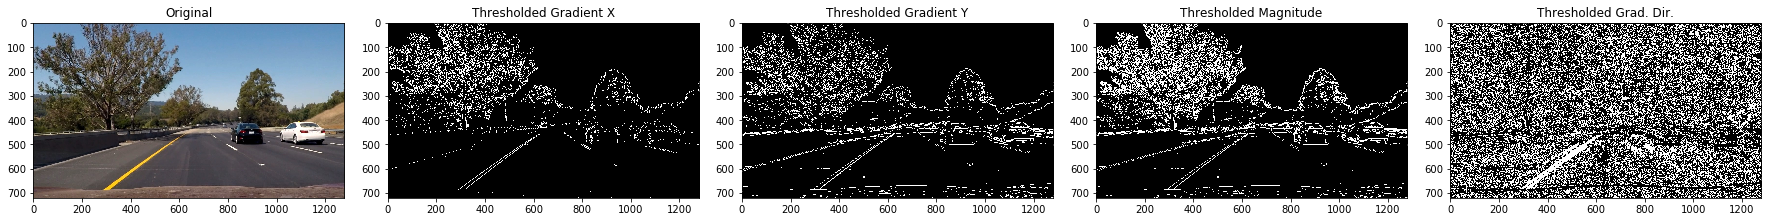

In [8]:
show_images([{"title": "Original", "image": cv2.cvtColor(image, cv2.COLOR_BGR2RGB)},
             {"title": "Thresholded Gradient X", "image": grad_x_binary, "cmap": "gray"},
             {"title": "Thresholded Gradient Y", "image": grad_y_binary, "cmap": "gray"},
             {"title": "Thresholded Magnitude", "image": mag_binary, "cmap": "gray"},
             {"title": "Thresholded Grad. Dir.", "image": dir_binary, "cmap": "gray"}])

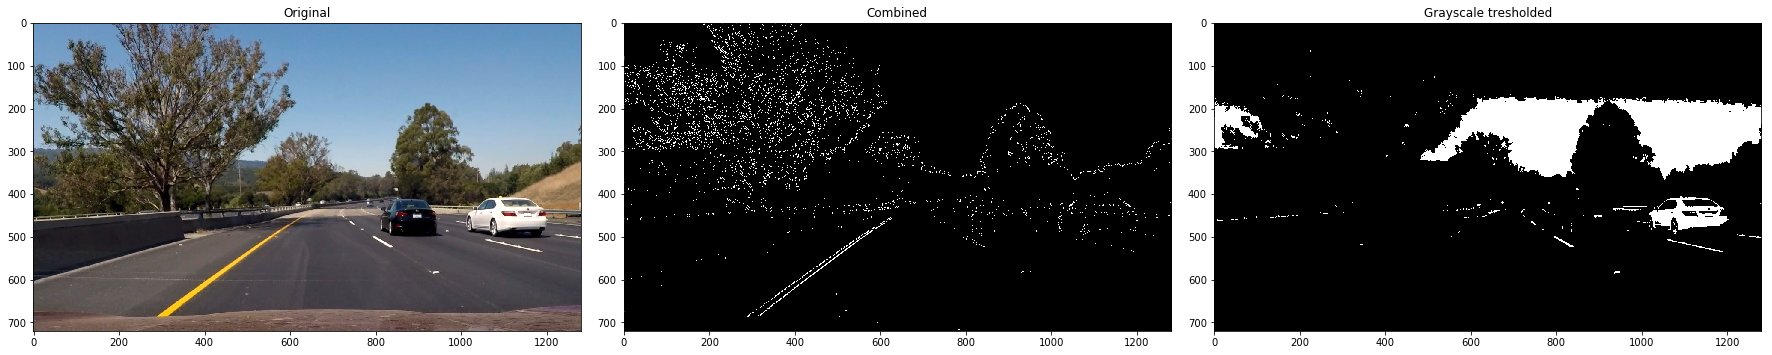

In [9]:
combined = np.zeros_like(dir_binary)
combined[((grad_x_binary == 1) & (grad_y_binary == 1)) & ((mag_binary == 1) | (dir_binary == 1))] = 1

thresh = (180, 255)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
binary = np.zeros_like(gray)
binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1

show_images([{"title": "Original", "image": cv2.cvtColor(image, cv2.COLOR_BGR2RGB)},
             {"title": "Combined", "image": combined, "cmap": "gray"},
             {"title": "Grayscale tresholded", "image": binary, "cmap": "gray"},])

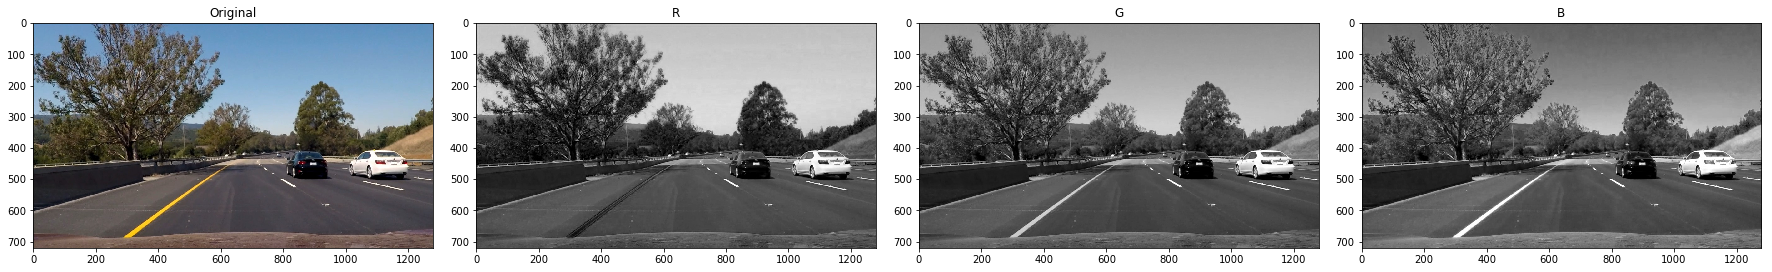

In [10]:
R = image[:,:,0]
G = image[:,:,1]
B = image[:,:,2]

show_images([{"title": "Original", "image": cv2.cvtColor(image, cv2.COLOR_BGR2RGB)},
             {"title": "R", "image": R, "cmap": "gray"},
             {"title": "G", "image": G, "cmap": "gray"},
             {"title": "B", "image": B, "cmap": "gray"},])

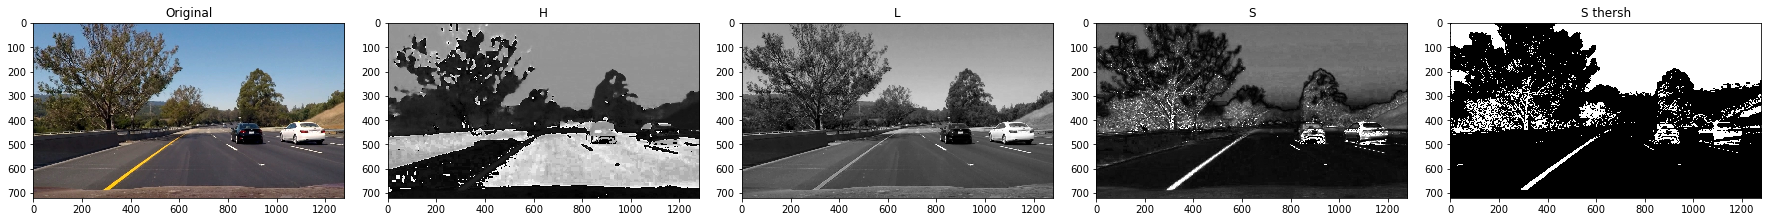

In [11]:
hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

thresh = (90, 255)
binary_s = np.zeros_like(S)
binary_s [(S > thresh[0]) & (S <= thresh[1])] = 1


show_images([{"title": "Original", "image": cv2.cvtColor(image, cv2.COLOR_BGR2RGB)},
             {"title": "H", "image": H, "cmap": "gray"},
             {"title": "L", "image": L, "cmap": "gray"},
             {"title": "S", "image": S, "cmap": "gray"},
             {"title": "S thersh", "image": binary_s, "cmap": "gray"},])

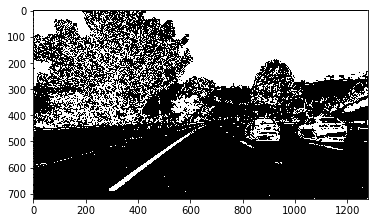

In [12]:
combined_binary = np.zeros_like(grad_x_binary)
combined_binary[(binary_s == 1) | (grad_x_binary == 1)] = 1

plt.imshow(combined_binary, cmap="gray")

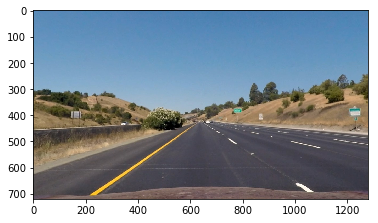

In [13]:
image = mpimg.imread('test_images/straight_lines1.jpg')


dst = cv2.undistort(image, mtx, dist, None, mtx)
plt.imshow(dst)

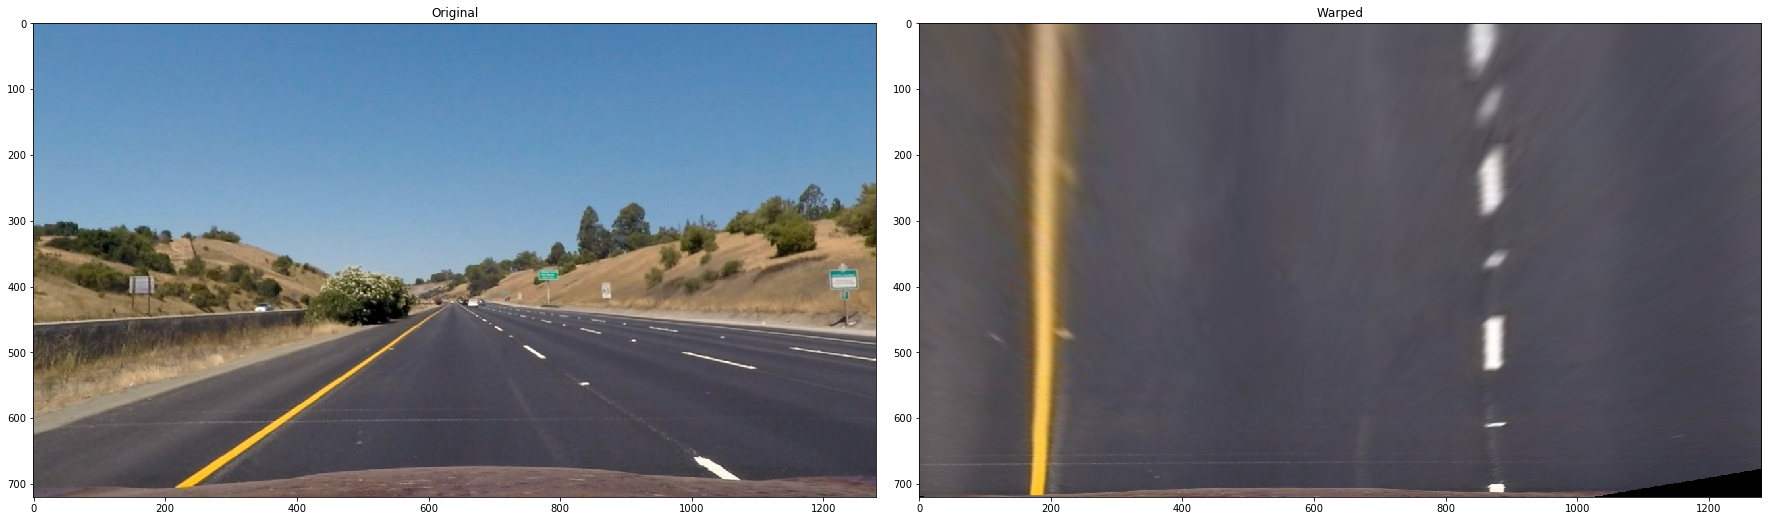

In [29]:
def perspective(image):
    size = (image.shape[1], image.shape[0])
    
#     plt.imshow(image)
#     plt.plot(690,  450, ".")
#     plt.plot(1100, 700, ".")
#     plt.plot(200,  700, ".")
#     plt.plot(590,  450, ".")
    
    src = np.float32([[690, 450],
                      [1100, 700],
                      [200, 700],
                      [590, 450]])
    
    
    dst = np.float32([[900, 0],
                      [900, 715],
                      [150, 715],
                      [150, 0]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    
    return M, Minv, cv2.warpPerspective(image, M, size, flags=cv2.INTER_LINEAR)
    
    

M, Minv, warped = perspective(dst)

show_images([{"title": "Original", "image": dst},
             {"title": "Warped", "image": warped},])

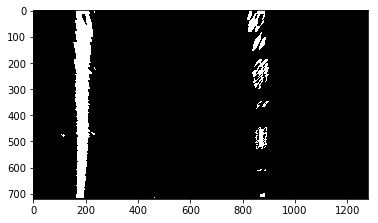

In [31]:
M, Minv, warped_combined_binary = process_frame(image)

plt.imshow(warped_combined_binary, cmap="gray")

/Users/dis/miniconda3/envs/carnd-term1-gpu/lib/python3.5/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


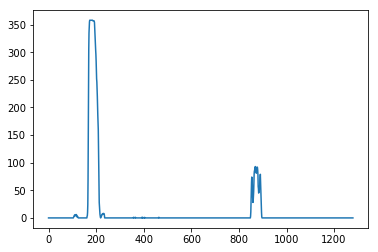

In [32]:
histogram = np.sum(warped_combined_binary[warped_combined_binary.shape[0]/2:,:], axis=0)
plt.plot(histogram)

In [47]:
def find_curved_lines(frame, original, Minv):
    
    histogram = np.sum(frame[frame.shape[0]/2:,:], axis=0)
    out_img = np.dstack((frame, frame, frame))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(frame.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = frame.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = frame.shape[0] - (window+1)*window_height
        win_y_high = frame.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Draw result
    ploty = np.linspace(0, frame.shape[0]-1, frame.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    
#     plt.imshow(out_img)
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)
    
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (original.shape[1], original.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(original, 1, newwarp, 0.3, 0)   
    return result

/Users/dis/miniconda3/envs/carnd-term1-gpu/lib/python3.5/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


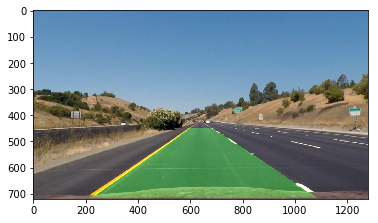

In [48]:
def process_frame(frame):
    dst = cv2.undistort(frame, mtx, dist, None, mtx)
    grad_x_binary = abs_sobel_thresh(dst, orient='x', thresh_min=30, thresh_max=100)
    
    
    hls = cv2.cvtColor(dst, cv2.COLOR_BGR2HLS)
    S = hls[:,:,2]

    thresh = (90, 255)
    binary_s = np.zeros_like(S)
    binary_s [(S > thresh[0]) & (S <= thresh[1])] = 1
    
    combined_binary = np.zeros_like(grad_x_binary)
    combined_binary[(binary_s == 1) | (grad_x_binary == 1)] = 1
    
    M, Minv, warped_combined_binary = perspective(combined_binary)
    
    return find_curved_lines(warped_combined_binary, dst, Minv)

res = process_frame(image)

plt.imshow(res)
 

/Users/dis/miniconda3/envs/carnd-term1-gpu/lib/python3.5/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


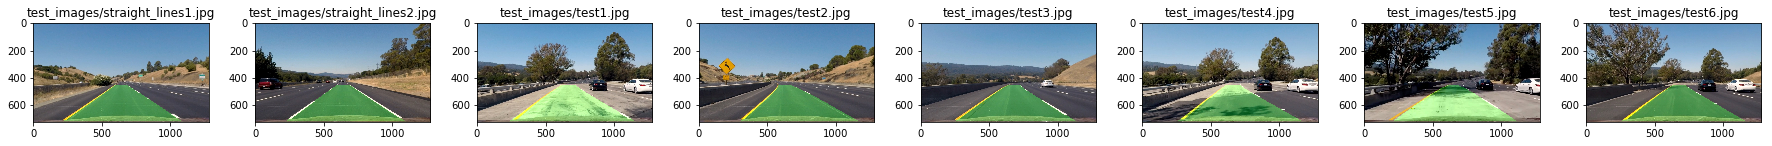

In [53]:
def check_on_test_images(folder):
    images = glob.glob(folder + '*.jpg')    

    res = []
    for f in images:
        image = cv2.imread(f)
        
        res.append({"image": cv2.cvtColor(process_frame(image), cv2.COLOR_BGR2RGB),
                    "title": f})
    return res

show_images(check_on_test_images("test_images/"))

In [55]:

from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'project_video_output.mp4'
clip = VideoFileClip('project_video.mp4')
project_clip = clip.fl_image(process_frame)
%time project_clip.write_videofile(output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [02:13<00:00,  9.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 2min 59s, sys: 29.9 s, total: 3min 29s
Wall time: 2min 14s


In [56]:
# output = 'challenge_video_output.mp4'
# clip = VideoFileClip('challenge_video.mp4')
# project_clip = clip.fl_image(process_frame)
# %time project_clip.write_videofile(output, audio=False)

# HTML("""
# <video width="960" height="540" controls>
#   <source src="{0}">
# </video>
# """.format(output))

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 485/485 [00:43<00:00, 11.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 1min 3s, sys: 8.72 s, total: 1min 12s
Wall time: 44 s


In [57]:
# output = 'harder_challenge_video_output.mp4'
# clip = VideoFileClip('harder_challenge_video.mp4')
# project_clip = clip.fl_image(process_frame)
# %time project_clip.write_videofile(output, audio=False)

# HTML("""
# <video width="960" height="540" controls>
#   <source src="{0}">
# </video>
# """.format(output))

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [02:21<00:00,  9.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

CPU times: user 3min 4s, sys: 32.4 s, total: 3min 37s
Wall time: 2min 22s


In [36]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((wrapped_combined_binary, wrapped_combined_binary, wrapped_combined_binary))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

NameError: name 'nonzeroy' is not defined

In [ ]:
# # Assume you now have a new warped binary image 
# # from the next frame of video (also called "binary_warped")
# # It's now much easier to find line pixels!
# nonzero = binary_warped.nonzero()
# nonzeroy = np.array(nonzero[0])
# nonzerox = np.array(nonzero[1])
# margin = 100
# left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
# right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# # Again, extract left and right line pixel positions
# leftx = nonzerox[left_lane_inds]
# lefty = nonzeroy[left_lane_inds] 
# rightx = nonzerox[right_lane_inds]
# righty = nonzeroy[right_lane_inds]
# # Fit a second order polynomial to each
# left_fit = np.polyfit(lefty, leftx, 2)
# right_fit = np.polyfit(righty, rightx, 2)
# # Generate x and y values for plotting
# ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
# left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
# right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


# out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# window_img = np.zeros_like(out_img)
# # Color in left and right line pixels
# out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
# out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# # Generate a polygon to illustrate the search window area
# # And recast the x and y points into usable format for cv2.fillPoly()
# left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
# left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
# left_line_pts = np.hstack((left_line_window1, left_line_window2))
# right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
# right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
# right_line_pts = np.hstack((right_line_window1, right_line_window2))

# # Draw the lane onto the warped blank image
# cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
# cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
# result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
# plt.imshow(result)
# plt.plot(left_fitx, ploty, color='yellow')
# plt.plot(right_fitx, ploty, color='yellow')
# plt.xlim(0, 1280)
# plt.ylim(720, 0)


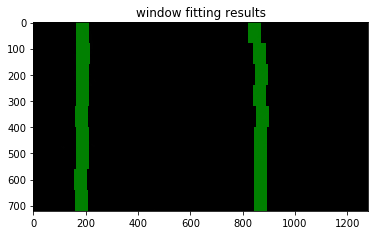

In [37]:

warped = warped_combined_binary
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channle 
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 

# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()


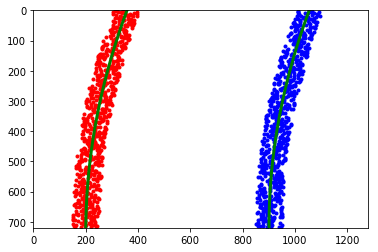

In [38]:
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [39]:

# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48


1709.34060547 1663.00688177


In [40]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m


561.378919389 m 546.215247544 m


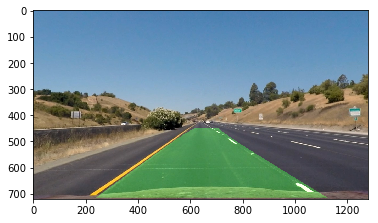

In [42]:

ploty = np.linspace(0, wrapped_combined_binary.shape[0]-1, wrapped_combined_binary.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (dst.shape[1], dst.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(dst, 1, newwarp, 0.3, 0)
plt.imshow(result)